<a href="https://colab.research.google.com/github/MainN/diploma/blob/master/test_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pystan
!pip install stan_utility
!pip install arviz

     |████████████████████████████████| 1.6MB 6.2MB/s 
     |████████████████████████████████| 768kB 22.2MB/s 
     |████████████████████████████████| 4.7MB 29.1MB/s 
     |████████████████████████████████| 317kB 40.6MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [2]:
import os
import pystan
import seaborn as sns
import pandas as pd
from math import exp, cos, pi, log
import stan_utility
import numpy as np
import arviz

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
My_data=pd.read_csv("/content/gdrive/My Drive/data.csv")
My_data=My_data.fillna(0)
My_data


,t5,t6,t9,t12,t15,t20
0,386.0,249.0,108.0,66.0,67.0,59.0
1,281.0,229.0,39.0,38.0,0.0,18.0
2,0.0,115.0,0.0,0.0,0.0,28.0
3,122.0,0.0,105.0,21.0,34.0,32.0
4,868.0,482.0,370.0,0.0,98.0,72.0
...,...,...,...,...,...,...
159,463.0,254.0,0.0,97.0,0.0,47.0
160,478.0,93.0,0.0,38.0,23.0,20.0
161,0.0,402.0,0.0,0.0,26.0,20.0
162,159.0,100.0,48.0,31.0,14.0,12.0


In [5]:
code ='''
data {
    int  T ;  // Time
    int  N ;  // number of individuals
    real time[T]; // time measurements
    real dset[N,T]; // data
    
 }
parameters {
    real b0;
    real b1;
    vector[N] C;
    real<lower = 0> delta_C;
    real<lower = 0> delta_ERR;
}
model {
    delta_ERR ~ exponential(1);
    delta_C ~ gamma(2,2);
    b0 ~ normal(0,1);
    b1 ~ normal(0,1);
    C ~ normal(0,delta_C);
    for (t in 1:T) {
        for (i in 1:N) {
            if (dset[i,t] != 0)  {dset[i,t] ~ normal(C[i] + b0 + b1 * time[t],delta_ERR);}
        }
    }
}
'''
sm = pystan.StanModel(model_code=code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f5f59efc46c43c303367e9769adb6f19 NOW.


In [21]:
T=6
time =[log(x) for x in [1,2,5,8,11,16]]
N = 1#len(My_data)
data  = dict(
        T=T,
        N=N,
        dset=[time],
        time=time)
init = dict(
    b0 = 6,
    b1 = -2,
    C = [0]*N,
    delta_C=0.2,
    delta_ERR=1)  


In [22]:
fit = sm.sampling(data=data, iter=10000, chains=4, init=[init]*4,thin=1, control={"adapt_delta":0.9})
op = fit.extract()  

In [23]:
print(fit)

Inference for Stan model: anon_model_f5f59efc46c43c303367e9769adb6f19.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b0         -0.17    0.09   0.14  -0.44   -0.3  -0.08  -0.04  -0.03      2   3.27
b1           1.0  6.2e-8 8.6e-6    1.0    1.0    1.0    1.0    1.0  19350    1.0
C[1]        0.17    0.09   0.14   0.03   0.04   0.08    0.3   0.44      2   3.27
delta_C     0.43    0.11   0.25    0.2   0.23   0.34   0.58    1.1      5   2.32
delta_ERR 9.8e-6  6.2e-6 9.5e-6 8.8e-7 1.6e-6 5.8e-6 1.7e-5 3.2e-5      2   2.88
lp__        45.1    3.46   5.08  36.98  40.67  44.57  49.81  52.92      2   3.68

Samples were drawn using NUTS at Sat Apr 24 09:14:50 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [24]:
print(op.keys())
print(len(op['b0']))

odict_keys(['b0', 'b1', 'C', 'delta_C', 'delta_ERR', 'lp__'])
20000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe7482b750>,
      dtype=object)

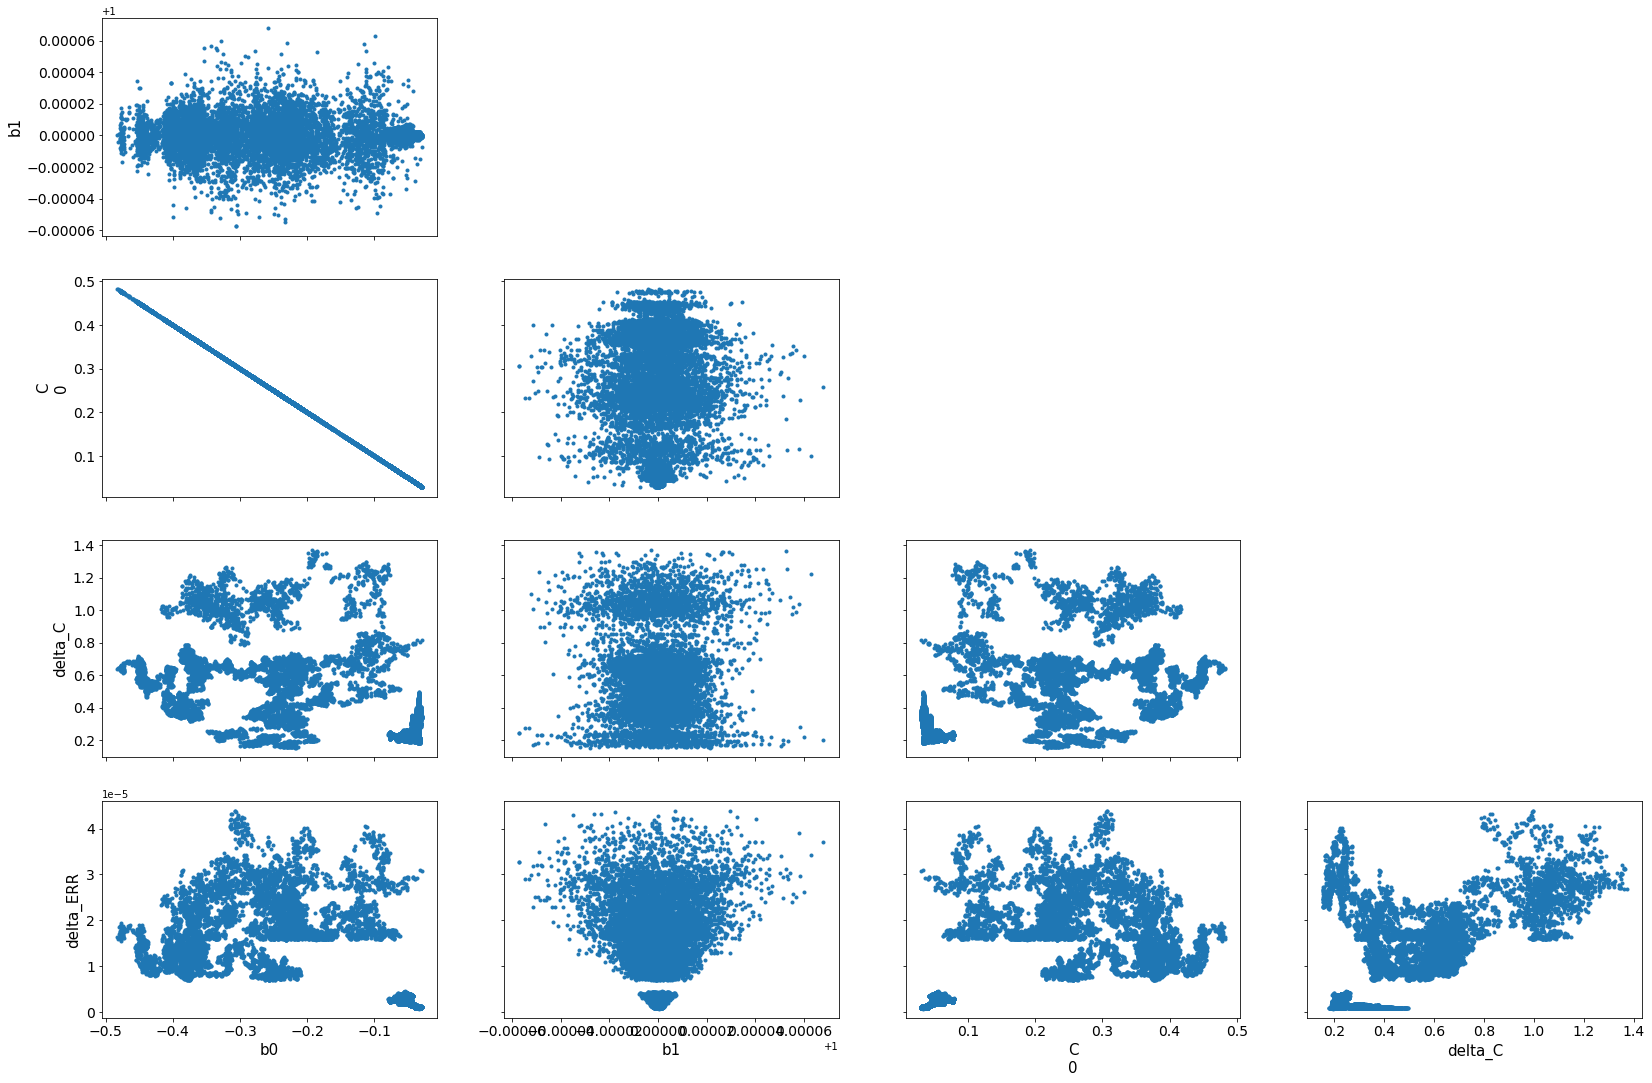

In [25]:
arviz.plot_pair(fit)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe745bbc10>,
      dtype=object)

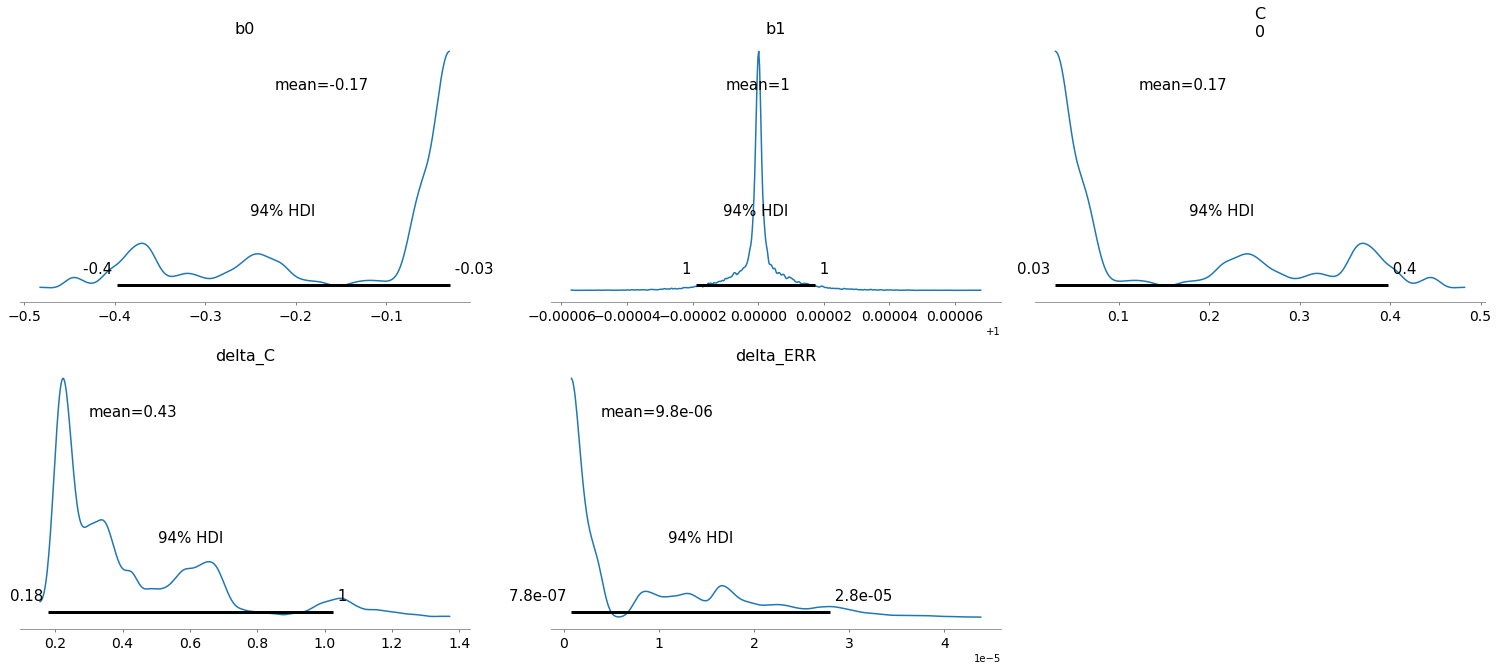

In [26]:
arviz.plot_posterior(fit)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe7ebc4050>,
      dtype=object)

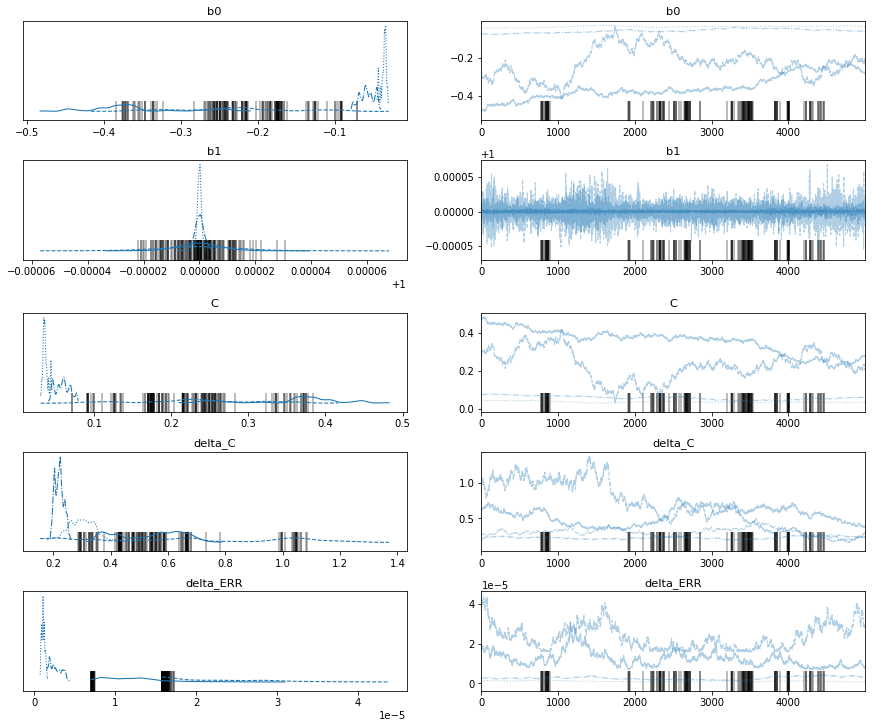

In [27]:
arviz.plot_trace(fit)

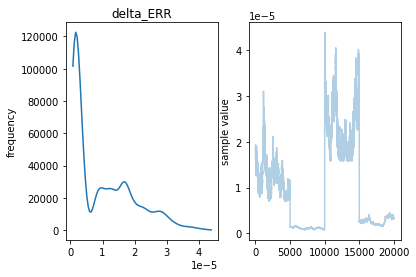

In [28]:
fit.plot('delta_ERR');

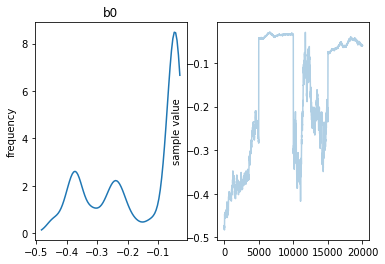

In [29]:
fit.plot('b0');

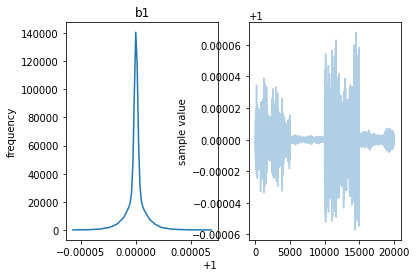

In [30]:
fit.plot('b1');

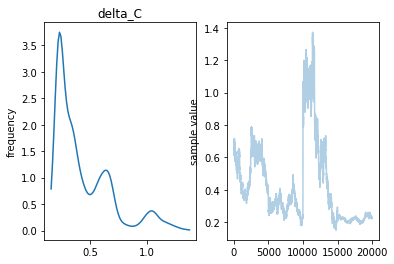

In [31]:
fit.plot('delta_C');

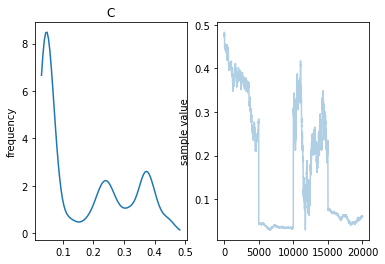

In [32]:
fit.plot('C');